<DIV ALIGN=CENTER>

# Introduction to Dask
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

Previously, we explored the [Pandas library][pl], which introduced the
concept of a DataFrame into the Python data science software stack.
Pandas, and in particular a Pandas DataFrame, simplifies the process of
exploring data from within a Python program or Notebook. Pandas,
however, does not excel at exploring or analyzing large data sets,
where the quantity large id determined primarily by the computational
power of the system being used. At the other end of the scale are the
**big data** technologies like Hadoop, which was designed to bulk
process very large data, which currently means multiple Petabytes or
more.

However, Hadoop lacks the flexibility of Pandas, and since [many **big
data** jobs aren't that big][msrpt] (or at least don't start out that
big, as one explores a data set), there remains a middle ground where
relatively large data sets are underserved. We are currently seeing an
[explosion of technologies][exp] that are attempting to capitalize on
this unmet need. This has the disadvantage of complicating the
landscape (which technology should I choose), while still offering the
advantage of promising a brighter future (at least when the dust
settles). Particular technologies that are in this space include:

- [Ibis](http://www.ibis-project.org)
- [SFrame](https://dato.com/products/create/docs/generated/graphlab.SFrame.html)
- [Dask](http://dask.pydata.org/en/latest/)

In this IPython Notebook, we explore using dask to perform data
processing in a similar maner to our previous efforts with Pandas. Dask
is a task scheduler that can operate on data out-of-core, by chunking up
data and scheduling computations over the available cores. Dask
includes collection data structures that simplify this process, but also
provides direct support for creating and executing task graphs directly.
Before exploring the dask collections, we first look at the concept of a
task graph by leveraging a simple example.

-----
[pl]: ../Week1/pyde.ipynb
[exp]: http://www.galvanize.com/blog/2015/07/31/eight-tools-that-show-whats-on-the-horizon-for-the-python-data-ecosystem/#.VfnT3bSpROF
[msrpt]: http://research.microsoft.com/pubs/179615/msrtr-2013-2.pdf

### Functional programming

A key concept behind dask (and other similar libraries) is the execution
of functions over data. This concepts actually underlies some entire
programming languges, like lisp. Python supports a large fraction of the
basic functional programming constructs through the `map` function and
lambdas. To demonstrate this basic concept, the following code cells
first define two basic functions: `plus` and `minus`. We use these two
functions to process simple data in the following code cell (in a manner
we typically expect), which produces the expected output. 

----- 

In [1]:
def plus(x, y):
    return x + y

def minus(x, y):
    return x - y

In [2]:
a = 9
b = plus(a, 1)

x = 2
y = plus(x, 7)

z = minus(b, y)
z

1

-----

### Task Graphs

The code executed in the previous cell can be rewritten into a task
graph, which is simply an ordered structure of functions and their
arguments. This is demonstrated in the following cell, where we create a
dictionary that maps values to variables, and arguments to functions as
an ordered sequence. The Dask library includes a method that displays a
task graph, which is shown in the second code cell.

-----

In [3]:
dsk = {'a': 9, 
       'b': (plus, 'a', 1),
       
       'x': 2,
       'y': (plus, 'x', 7),
       
       'z': (minus, 'b', 'y')}

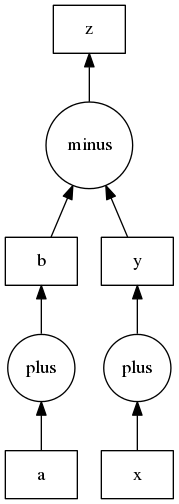

In [4]:
from dask.dot import dot_graph
dot_graph(dsk)

-----

The task graph clearly shows how data are processed by functions, and
how the functions are chained together to produce the final output. We
can verify our simple task graph operates as expected by _getting_ the
desired value from the graph. Note that this actually has the effect of
**executing** the task graph, since, by default, Dask employs lazy
execution. This means results re only computed as needed, and allows
complex task graphs to be built and analyzed for optimal performance on
a specific hardware platform.

-----

In [5]:
#We can obtain the result of the task graph by using get
import dask as da

da.get(dsk, 'z')

1

-----

### Dask 

Writing task graphs out by hand is likely not an attractive solution for
the typical Python programmer. Fortunately, Dask provides three data
structures that hide this complexity while still providing the benefits:

- [`bag`][b]: parallelize processing across large quantities of generic
data, including unstructured or semi-structured data like log files.

- [`array`][a]: supports processing large arrays via blocking and
implements a subset of the numpy interface.

- [`DataFrame`][df]: supports processing large structured data sets via
blocking and implements a subset of the Pandas interface.

In the next few sections, we introduce each of these collections.

----
[b]: http://dask.pydata.org/en/latest/bag.html
[a]: http://dask.pydata.org/en/latest/array.html
[df]: http://dask.pydata.org/en/latest/dataframe.html

-----

### `dask.bag`

A Dask bag supports processing generic data, to demonstrate this, we can
read in a JSON file (in this case we simply read in one of our IPython
Notebooks) to create the bag. Note that since we employ lazy evaluation,
the collection isn't populated until we perform an action, in this case
that `take` method in the second cell that displays a subset of the
entire structure.

-----

In [6]:
import dask.bag as db

b = db.from_filenames('intro2spark.ipynb')

In [7]:
b.take(250)

('{\n',
 ' "cells": [\n',
 '  {\n',
 '   "cell_type": "markdown",\n',
 '   "metadata": {},\n',
 '   "source": [\n',
 '    "<DIV ALIGN=CENTER>\\n",\n',
 '    "\\n",\n',
 '    "# Introduction to Spark\\n",\n',
 '    "## Professor Robert J. Brunner\\n",\n',
 '    "  \\n",\n',
 '    "</DIV>  \\n",\n',
 '    "-----\\n",\n',
 '    "-----"\n',
 '   ]\n',
 '  },\n',
 '  {\n',
 '   "cell_type": "markdown",\n',
 '   "metadata": {},\n',
 '   "source": [\n',
 '    "## Introduction\\n",\n',
 '    "\\n",\n',
 '    "Previously in this course, we have discussed doing data science at the\\n",\n',
 '    "Unix command line, and with Python, primarily by using Pandas. We also\\n",\n',
 '    "have discussed other Python libraries that bring new functionalities to\\n",\n',
 '    "the Python data science stack. Other _big data_ technologies, however,\\n",\n',
 '    "also exist and can be relevant to particular data science\\n",\n',
 '    "investigations, depending on the scale of data. Of these other\\n",\n'

-----

Given this collection, we can create tranformations by using functional
programming concepts. Simply put, we will apply functions to the
collection to transform data, to filter data, or to compute a result.
This is demonstrated in the next code cell, where we apply a filter to
the bag to produce a collection of the rows in the bag that contain the
work `markdown`, after which we compute the count of rows that meet this
criterion. The following code cell displays the task graph for this
filter and compute process.

Note that the task graph is not actually processed until we apply the
`compute` method in the third code cell, where he result is displayed
(you can check this answer for accuracy by using `grep` at the Unix
command prompt).

-----

In [8]:
the_count = b.filter(lambda line: 'markdown' in line).count()

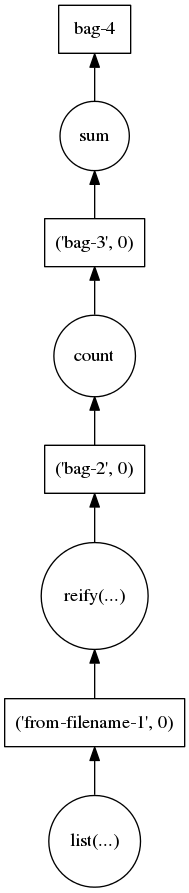

In [9]:
dot_graph(the_count.dask)

In [10]:
print(the_count.compute())

22


-----

### `dask.array`

The dask array is similar to the numpy array, as it implements a subset
of the overall numpy functionality. the dask array, however, was
designed to operate efficiently on very large arrays. We can demonstrate
the dask array by first showing a simple numpy array example, and next
translating this into a dask array example (including a visual
demonstration of the resultant task graph). This simple example first
generates a large number of uniformly sampled data, next computes a
nonlinear function of these data, and finally computes the mean value of
the new data. As a final step, we print out this mean value.

-----

In [11]:
import numpy as np

# Create linearly spaced array
x = np.linspace(0.0, np.pi, 10000)

# Create new array
y = x * 2.0 - x / 2.0 + 1

# Find mean value
mu = np.mean(y)
print("Mean value = ", mu)

Mean value =  3.35619449019


In [12]:
import dask.array as da

# Create Dask Array from our numpy array
# chunksize will affect task graph.
xx = da.from_array(x, chunks=5000)

# multiply this array by a factor
yy = xx * 2.0 - xx / 2.0 + 1

# Find mean value
mu = da.mean(yy)
print("Mean value = ", mu)

Mean value =  dask.array<atop-d766e298f7f48ec76d76496178122dda, shape=(), chunks=(), dtype=float64>


-----

As shown in the two preceding code cells, the dask array is identical in
interface to the numpy array (since we restricted ourselves to the set
of dask implemented numpy functionality). Hopwever, the final step
shows the difference, since the mean value is not displayed with the
print statement; `mu` is an instance of a dask array and not an actual
value. We can see this order of operations in the following task graph,
after which, we actually display the computed mean value by issuing a
`compute` method invocation.

------

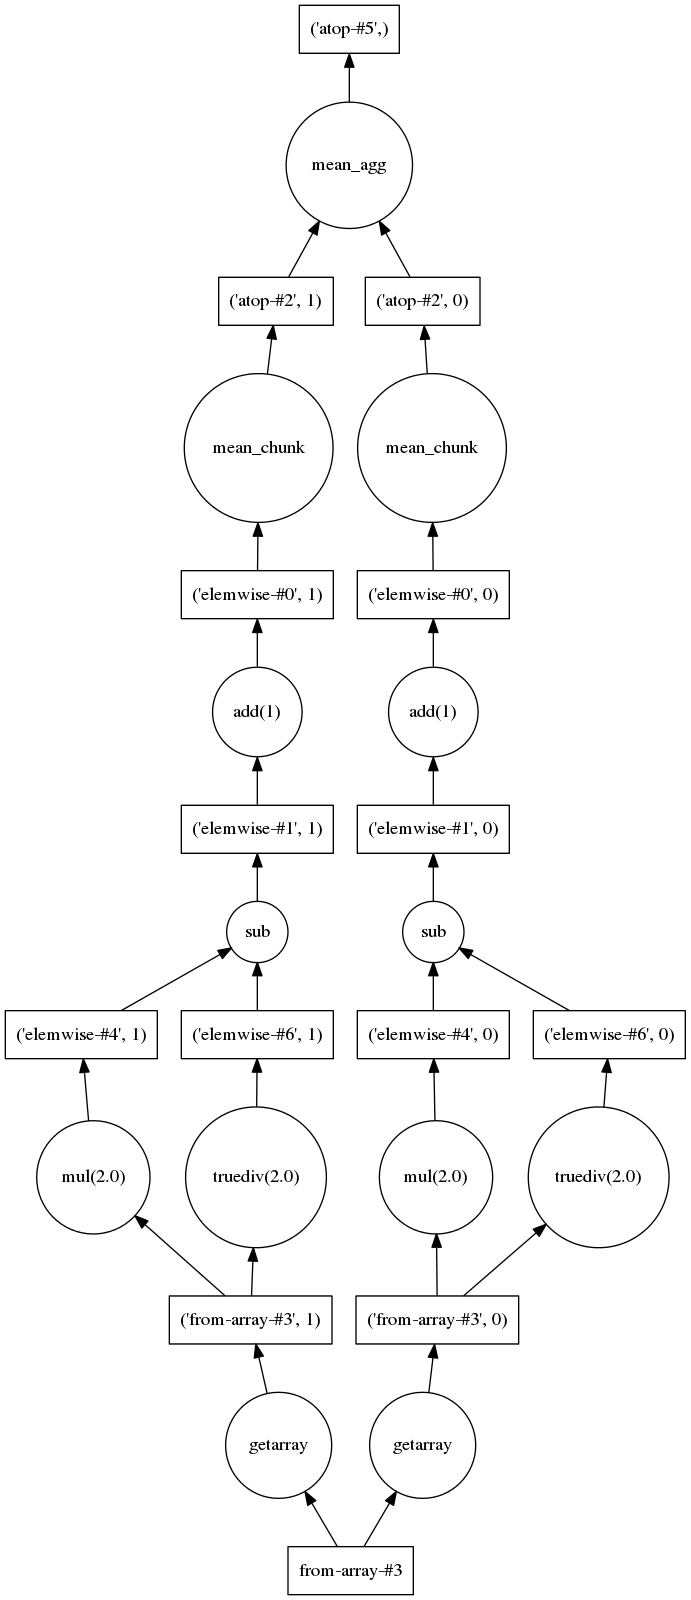

In [13]:
dot_graph(mu.dask)

In [14]:
print("Mean value = ", mu.compute())

Mean value =  3.35619449019


-----

### `dask.dataframe`

The final dask collection is the dataframe, which implements a subset
of the Pandas DataFrame and is thus current;y of the most interest to
us. To demonstrate using a dask dataframe, we will return to our flight
data, specifically the 2001 airline flight data. We read the data into a
dask dataframe, which is nearly identical to the Pandas process,
however, the process is much faster since dask employs lazy evaluation.
The actual data isn't read and processed until the following code cell
where we display the first few rows with a call to the `head` method,
after which we show the last few rows with a call to the `tail` method,
in a similar manner as we would with Pandas.

-----

In [15]:
# Read select columns for all rows.

import dask.dataframe as dd

# Change this to read a different file, for example
# /home/data_scientist/data/2001.csv on the JupyterHub Server
# /home/data_scientist/rppdm/data/2001.csv on local Docker Container
#
# Note that the JupyterHub server has data from other years in the raw
# subdirectory.
#

infile = '/home/data_scientist/data/2001.csv'

ucs = (1, 2, 4, 14, 15, 16, 17, 18)
cnms = ['Month', 'Day', 'dTime', 'aDelay', 'dDelay', 'Depart', 'Arrive', 'Distance']

%time alldata = dd.read_csv(infile, header=0, na_values=['NA'], \
                         usecols=ucs, names=cnms)

#alldata.memory_usage(index=True)

CPU times: user 25.2 ms, sys: 16.9 ms, total: 42.1 ms
Wall time: 44.7 ms


In [16]:
alldata.head(10)

,Month,Day,dTime,aDelay,dDelay,Depart,Arrive,Distance
0,1,17,1806,-3,-4,BWI,CLT,361
1,1,18,1805,4,-5,BWI,CLT,361
2,1,19,1821,23,11,BWI,CLT,361
3,1,20,1807,10,-3,BWI,CLT,361
4,1,21,1810,20,0,BWI,CLT,361
5,1,22,1807,-3,-3,BWI,CLT,361
6,1,23,1802,-10,-8,BWI,CLT,361
7,1,24,1804,-12,-6,BWI,CLT,361
8,1,25,1812,-9,2,BWI,CLT,361
9,1,26,1812,-1,2,BWI,CLT,361


In [17]:
alldata.tail()

,Month,Day,dTime,aDelay,dDelay,Depart,Arrive,Distance
293766,12,14,704,4,4,ONT,DFW,1189
293767,12,15,708,3,8,ONT,DFW,1189
293768,12,16,656,-8,-4,ONT,DFW,1189
293769,12,17,656,-4,-4,ONT,DFW,1189
293770,12,18,709,3,9,ONT,DFW,1189


-----

We can often use dask dataframes in places where we normally might use a
Pandas DataFrame. For example, we can make a distance histogram plot of
the data in our dask dataframe by using seaborn.

-----

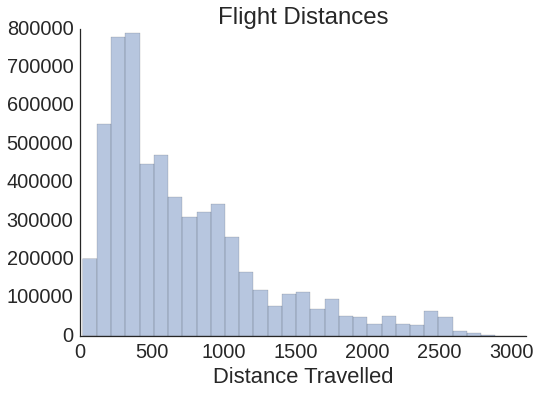

In [18]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", font_scale=2.0)

ax = sns.distplot(alldata['Distance'], kde=False)

ax.set(title='Flight Distances', \
       xlabel='Distance Travelled', xlim=(0, 3100))


sns.despine()

-----

### Column Data Storage

For structured data we often visualize the data as a row-ordered table. 
From a relational database standpoint, this maks sense as rows are
consistent entities. In many cases, however, we do not want or need an
entire row and thus pay an overhead for maintaining this viewpoint. In
addition, we often increase our storage requirements (and thus data
processing requirements) since we can't take advantage of natural
compression that might be possible when we view the same data in a
column oriented fashion. 

For example, this is demonstrated in the following code cell, where we
display the first ten rows of the flight data. Constant or even slowly
changing data can be easily compressed, minimizing both dta storage and
data transport latencies. This column viewpoint has grown in popularity,
and several implementations, such as [Redshift][hb] or [Parquet][pq]. 

-----

[hb]: http://docs.aws.amazon.com/redshift/latest/dg/welcome.html
[pq]: https://github.com/apache/parquet-format

In [19]:
import pandas as pd

# Change this to read a different file, for example
# /home/data_scientist/data/2001.csv on the JupyterHub Server
# /home/data_scientist/rppdm/data/2001.csv on the local Docker container
#
# Note that the JupyterHub server has data from other years in the raw
# subdirectory.
#
filename = '/home/data_scientist/data/2001.csv'

pd.read_csv(filename, header = 0, nrows = 10, encoding='latin-1')

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2001,1,17,3,1806,1810,1931,1934,US,375,...,5,20,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2001,1,18,4,1805,1810,1938,1934,US,375,...,9,20,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2001,1,19,5,1821,1810,1957,1934,US,375,...,6,10,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2001,1,20,6,1807,1810,1944,1934,US,375,...,4,27,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2001,1,21,7,1810,1810,1954,1934,US,375,...,4,38,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5,2001,1,22,1,1807,1810,1931,1934,US,375,...,12,11,0,NaN,0,NaN,NaN,NaN,NaN,NaN
6,2001,1,23,2,1802,1810,1924,1934,US,375,...,5,16,0,NaN,0,NaN,NaN,NaN,NaN,NaN
7,2001,1,24,3,1804,1810,1922,1934,US,375,...,4,14,0,NaN,0,NaN,NaN,NaN,NaN,NaN
8,2001,1,25,4,1812,1810,1925,1934,US,375,...,6,15,0,NaN,0,NaN,NaN,NaN,NaN,NaN
9,2001,1,26,5,1812,1810,1933,1934,US,375,...,4,15,0,NaN,0,NaN,NaN,NaN,NaN,NaN


-----

### `castra`

To demonstrate a column store, we can use the Python [_castra_][c]
library. Castra implements a column store that integrates naturally with
a dask dataframe providing a disk-based, partitioned and compressed
archive. This can greatly improve data processing since we often want
all rows from a select few columns in a dataframe. To demonstrate, we
can take our flight info dask dataframe and persist this data in a
castra column data store, which can easily be done with the `to_castra`
method. First, however, we need to delete the existing column data
store, if it exists, since a column data store is generally only
supportive of appending.

Note that castra is still experimental, we are simply using it to
demonstrate the concept of a column data store with dask.

-----

[c]: https://github.com/blaze/castra

In [20]:
%%bash
# We delete the castra data store if it exists.

file="2001.castra"

if [ -d $file ]
then
    rm -rf $file
fi

In [21]:
# We can only write to our home directory on the Jupyter server.

outfile = '2001.castra'

alldata.to_castra(outfile)

-----

We can explore the format of this new data store by simply browsing
the Unix file system.

-----

In [22]:
!ls -la 2001.castra

total 84
drwxr-xr-x 21 data_scientist data_scientist 4096 Sep 16 21:50 .
drwxr-xr-x  4 data_scientist data_scientist 4096 Sep 16 21:49 ..
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:49 0--334905
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:49 1002522--1337520
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:49 1337521--1672329
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:49 1672330--2005414
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:49 2005415--2339760
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:49 2339761--2673724
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:49 2673725--3007455
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:50 3007456--3341889
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:50 3341890--3674906
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:49 334906--669518
drwxr-xr-x  2 data_scientist data_scientist 4096 Sep 16 21:50 3674907--4009721
dr

-----

We can retrieve data from this column store by simply indicating that we
wish to create a new dask dataframe from the given castra data store. In
this case, we also filter rows with missing data, and then compute the
mean value of the difference between arrival and departure delays. With
lazy evaluation, none of these steps are completed until we issue the
compute method call. For **_visual sugar_**, we also use the built-in
dask progress bar to highlight our progress.

-----

In [23]:
from dask.diagnostics import ProgressBar

df = dd.from_castra(outfile).dropna()

with ProgressBar():
    result = (df.aDelay - df.dDelay).mean().compute()
                    
print(result)

[########################################] | 100% Completed | 18.4s
-2.58702287849


-----
## Breakout Session

During this breakout, you should work with the previous Dask examples in
order to better learn how Dask works, and how it is different than other
Python approaches like Pandas. Specific problems you can attempt include
the following:

1. Modify the initial task graph by changing the valus of the variables
and recompute the result. Does the new task graph make sense?

2. Modify the array example to compute a different quantity (see the
[dask array interface][dai] for available functions). How does
performance compare? How does the relative perfomance change with
increasing array size?

Additional, more advanced problems:

1. Modify the dask dataframe example to display a regression plot of
arrival delay versus departure delay for flights leaving O'Hare.

2. Modify the dask dataframe example to process multiple flight data
files.

-----
[dai]: http://dask.pydata.org/en/latest/array-api.html

### Additional References

1. [Dask][d] official repository.
6. [Dask Tutorial][dt].
4. Dask [Example Notebooks][de].
1. [Castra][c] official repository.
2. [Blog Post][tl] demonstrating Dask and Castra.

-----
[d]: https://github.com/blaze/dask
[dt]: https://github.com/blaze/dask-tutorial
[de]: https://github.com/blaze/dask-examples
[c]: https://github.com/blaze/castra
[tl]: http://matthewrocklin.com/blog/work/2015/08/28/Storage/

### Return to the [Week Two](index.ipynb) index.

-----